# First, the environment

In [2]:
import sys
!{sys.executable} -m pip install umap-learn
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install shap
!{sys.executable} -m pip install gamma-facet
!{sys.executable} -m pip install sklearndf
!{sys.executable} -m pip install rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=f8b37d6eee984794607e192c509d4a7609a695a5a83d836ce8dae4efec4bb67f
  Stored in directory: /home/jovyan/.cache/pip/wheels/fb/99/10/ed2f3bc57ea29f540470eb43570929e30ae911b2d8353b2ee4
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55496 sha256=4c623829d9d39ffe10a141ad937f303414f25d57e34597b7aa2016beb2cf8038
  Stored in directory: /home/jovyan/.cache/pip/wheels/8d/ca/f1/f60e041b5c82ae83173373a8991be5419647bdcf64026fd91f
Successfully built umap-learn pynndescent
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.wh

In [104]:
# Set style
TEX_PARAMS = {
    "text.usetex": False,  # use LaTeX to write all text
    "pgf.rcfonts": False,  # Ignore Matplotlibrc
    "pgf.texsystem": "lualatex",  # hoping to avoid memory issues
}

In [105]:
# Set the random seed for reproducibility
RANDOM_SEED = 60

# Step 0. Read the raw data

In [106]:
import pathlib
import pandas as pd
import numpy as np
import os

In [107]:
# Set the folders needed
output_folder = pathlib.Path('./output/')
data_folder = pathlib.Path('./data/')
processed_folder = data_folder.joinpath('processed_test')
raw_data_folder = data_folder.joinpath('raw_data')

# Create all the subfolders to store the output files
if not output_folder.exists():
    os.mkdir(output_folder)
    os.mkdir(output_folder.joinpath('img'))
    os.mkdir(output_folder.joinpath('deployments'))
    os.mkdir(output_folder.joinpath('models'))
    os.mkdir(output_folder.joinpath('clusters'))

In [108]:
# Read the processed data
n_grouped_per_window = 5
df = pd.read_pickle(processed_folder.joinpath('df_complete.pkl'))
freqticks = np.load(processed_folder.joinpath('used_freqticks.npy'))
df_features_complete = df.iloc[:, :len(freqticks) * n_grouped_per_window]

print('Total amount of samples: ', len(df))
print('Included deployments...', len(df.etn_id.unique()))

Total amount of samples:  42117
Included deployments... 54


In [109]:
# Define the vars that will be used
ENV_LABELS = [
    'shipping',
    'season',
    'moon_phase',
    'day_moment',
    'benthic_habitat',
    'substrate',
    'seabed_habitat',
    'tide',
    'salinity',
    'temperature',
    'current',
    'bathymetry',
    'shipwreck_distance',
    'coast_dist'
]

CATEGORICAL_VARS = ['day_moment', 'benthic_habitat', 'substrate', 'seabed_habitat', 'moon_phase', 'season']
CATEGORICAL_SAMPLE = ['instrument_name', 'etn_id']
CYCLIC_VARS = ['season', 'moon_phase']

SAMPLE_LABELS = [
    'instrument_name',
    'instrument_depth',
    'etn_id',
    'campaign'
]


# Step 1. Artifacts removal
First all the data that is not ecologically relevant because it is created due to human artifacts will be automatically removed.

## Dimension reduction
To visualize the data in 2D, the UMAP algorithm is used. Documentation can be checked at: https://umap-learn.readthedocs.io/

In [110]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

First dimension reduction, this can take a while...


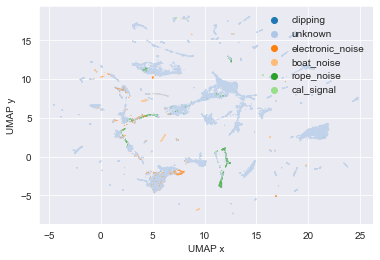

In [111]:
# Dimension reduction (for data cleaning of artifacts)
print('First dimension reduction, this can take a while...')
umap_mapper = umap.UMAP(n_neighbors=10, min_dist=0.0, n_components=2,
                        random_state=RANDOM_SEED).fit(df_features_complete.values)
x_umap_complete = umap_mapper.transform(df_features_complete.values)
df_umap_complete = pd.DataFrame(x_umap_complete)
df_umap_complete.to_pickle(data_folder.joinpath('processed/umap.pkl'))

# Create the figure of the artifacts plots on UMAP
sns.scatterplot(x=df_umap_complete.values[:, 0], y=df_umap_complete.values[:, 1], hue=df['label'], s=1,palette='tab20')
plt.xlabel('UMAP x')
plt.ylabel('UMAP y')
plt.legend(fancybox=True, framealpha=0.0)
plt.savefig(output_folder.joinpath('img/bad_data_labels.png'), dpi=350, transparent=True)
plt.show()


## Clustering

The clustering is done using the DBSCAN algorithm (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).
This algorithm creates a "noise" class from all the samples that can not be assigned to a certain cluster. This class is represented by a -1.

Checking for bad cluster data...


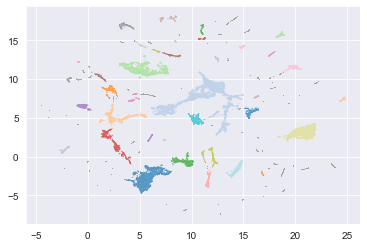

In [112]:
print('Checking for bad cluster data...')
predicted_clusters = DBSCAN(min_samples=100, eps=0.5).fit_predict(df_umap_complete)
noise_samples = predicted_clusters == -1
predicted_clusters_df = pd.DataFrame(predicted_clusters, index=df_umap_complete.index, columns=['clusters'])
predicted_clusters_df['label'] = df['label'].values

# Plot the obtained clusters
ax = sns.scatterplot(x=df_umap_complete.loc[noise_samples].values[:, 0], y=df_umap_complete.loc[noise_samples].values[:, 1],
                     label='noise', s=1, color=(0.5, 0.5, 0.5), legend=False)
sns.scatterplot(x=df_umap_complete.loc[~noise_samples].values[:, 0], y=df_umap_complete.loc[~noise_samples].values[:, 1],
                hue=predicted_clusters[~noise_samples].astype(str), s=1, ax=ax, palette='tab20', legend=False)

plt.savefig(output_folder.joinpath('img/clusters_bad_data.png'), dpi=350, transparent=True)
plt.show()

## Select and remove artifact clusters

Total amount of samples considered artifacts 4112
The threshold is: 0.19526556972243986
9 clusters will be eliminated: [1, 2, 6, 7, 14, 15, 27, 28, 29]
Total percentage of data removed: 15.30%


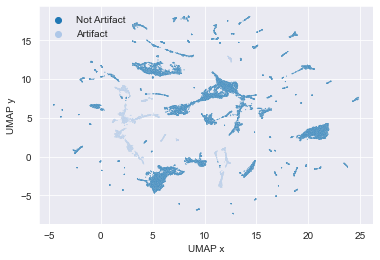

In [113]:
# Check the artifacts
n_artifacts = (df['label'] != 'unknown').sum()
print('Total amount of samples considered artifacts', n_artifacts)

# Get the threshold to remove a cluster
threshold = 2 * (n_artifacts / len(df))
print('The threshold is:', threshold)

# Iterate through the clusters
bad_data_clusters = []
for cl_n, cl in predicted_clusters_df.groupby('clusters'):
    bad_data_percentage = 1 - (cl['label'] == 'unknown').sum() / len(cl)
    # print(cl_n, bad_data_percentage)
    if bad_data_percentage > threshold:
        bad_data_clusters.append(cl_n)
print('%s clusters will be eliminated:' % len(bad_data_clusters), bad_data_clusters)

# Create the mask
mask = ~predicted_clusters_df['clusters'].isin(bad_data_clusters)
hue_labels = mask.replace(to_replace=True, value='Not Artifact')
hue_labels = hue_labels.replace(False, value='Artifact')

data_removed = (1 - mask.sum()/len(mask)) * 100
print('Total percentage of data removed: %.2f' % data_removed + r'%')

# Plot the data showing the selected clusters to remove
sns.scatterplot(x=df_umap_complete.values[:, 0], y=df_umap_complete.values[:, 1], hue=hue_labels, s=1,palette='tab20')
plt.xlabel('UMAP x')
plt.ylabel('UMAP y')
plt.legend(fancybox=True, framealpha=0.0)
plt.savefig(output_folder.joinpath('img/bad_data_to_remove.png'), dpi=350, transparent=True)
plt.show()

# Mask the selected data
df_umap = df_umap_complete.loc[mask]
df_clean = df.loc[mask]
df_features = df_features_complete.loc[mask]
df_clean.to_pickle(data_folder.joinpath('processed/df_no_artifacts.pkl'))
df_umap.to_pickle(data_folder.joinpath('processed/umap_clean_first_reduction.pkl'))

# Acoustic categorization
## Dimension reduction

Second dimension reduction... Some patience needed...


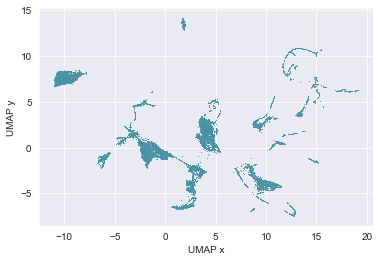

In [114]:
print('Second dimension reduction... Some patience needed...')
umap_mapper = umap.UMAP(n_neighbors=50, min_dist=0.0, n_components=2, random_state=RANDOM_SEED).fit(df_features.values)
x_umap = umap_mapper.transform(df_features.values)
df_umap = pd.DataFrame(x_umap)
df_umap.to_pickle(data_folder.joinpath('processed/umap_clean.pkl'))

# Create the figure of the final UMAP distribution on clean data
sns.scatterplot(x=df_umap.values[:, 0], y=df_umap.values[:, 1], color='#006582ff', s=1)
plt.xlabel('UMAP x')
plt.ylabel('UMAP y')
plt.savefig(output_folder.joinpath('img/umap_projection_clean_data.png'), dpi=350, transparent=True)
plt.show()

## Clustering

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


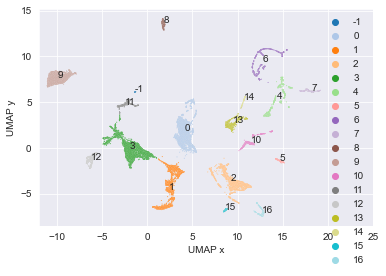

In [115]:
# Get the clusters
predicted_clusters = DBSCAN(min_samples=120, eps=0.9).fit_predict(df_umap)

# Add them to the df
df_clean = df_clean.assign(clusters=predicted_clusters)
df_clean.clusters = df_clean.clusters.astype('category')

# From now on, this will be the cmap used everywhere for consistency with the cluster colors!
unique_clusters = df_clean['clusters'].dtype.categories.values
cmap = plt.get_cmap('tab20', len(unique_clusters))
hue_order = np.arange(predicted_clusters.min(), predicted_clusters.max() + 1).astype(str)

# Plot the UMAP dimension with the final clusters
sns.scatterplot(x=x_umap[:, 0], y=x_umap[:, 1], hue=predicted_clusters.astype(str), hue_order=hue_order, s=1, palette=cmap.colors)
for cluster in np.unique(predicted_clusters):
        mask = predicted_clusters == cluster
        x_mean, y_mean = df_umap.loc[mask].mean()
        plt.text(x_mean, y_mean, cluster)
plt.xlabel('UMAP x')
plt.ylabel('UMAP y')
plt.xlim(-12, 25)
plt.legend(fancybox=True, framealpha=0.0)
plt.savefig(output_folder.joinpath('img/DBSCAN_clusters.png'), dpi=350, transparent=True)
plt.show()

# Explain the unexplained soundscapes. Acoustic and environmental characterization
## Prepare the data the right way

In [122]:
# Remove the noise clusters
deployments_folder = pathlib.Path(output_folder).joinpath('img/data_overview')
unique_clusters = df_clean['clusters'].dtype.categories.values
cmap = plt.get_cmap('tab20', len(unique_clusters))
noise_samples = predicted_clusters == -1
print('Total of noise samples', noise_samples.sum() / len(predicted_clusters))

# Remove the noise clusters
df_rf = df_clean.loc[~noise_samples]

# Get the percentage of samples per cluster
print(df_clean.value_counts(subset=['clusters'], sort=False) * 100 / len(df))

# Prepare the data for the RF
x = df_clean[ENV_LABELS + ['clusters']].copy()
x['clusters'] = x['clusters'].astype(str)
x = x.join(df_clean[['instrument_depth']])
for cy_var in CYCLIC_VARS:
    if cy_var == 'season':
        # Convert the week number into a degree
        x[cy_var] = x[cy_var] / 52 * 2 * np.pi
    x[cy_var + '_sin'] = np.sin(x[cy_var])
    x[cy_var + '_cos'] = np.cos(x[cy_var])
    x = x.drop([cy_var], axis=1)

x.rename(columns={'moon_phase_sin': 'growing_moon', 'moon_phase_cos': 'new_moon',
                  'season_sin': 'week_n_sin', 'season_cos': 'week_n_cos'},
         inplace=True)

x

Total of noise samples 0.0020463655986320186
clusters
-1           0.173327
0           13.027993
1           10.485077
2            9.582829
3           16.549137
4            4.311798
5            1.294014
6            2.414702
7            1.023340
8            2.177268
9           10.288007
10           2.395707
11           2.756607
12           2.160648
13           3.713465
14           0.277798
15           0.676686
16           1.391362
dtype: float64


,shipping,day_moment,benthic_habitat,substrate,seabed_habitat,tide,salinity,temperature,current,bathymetry,shipwreck_distance,coast_dist,clusters,instrument_depth,week_n_sin,week_n_cos,growing_moon,new_moon
0,127,Day,1.0,Sand,A5.25 or A5.26,-1.558594,30.21875,284.0,0.505859,8.359375,5.500000,1568,0,5.0,0.822984,-0.568065,0.951660,0.306885
1,127,Day,1.0,Sand,A5.25 or A5.26,-1.558594,30.21875,284.0,0.505859,8.359375,5.500000,1568,0,5.0,0.822984,-0.568065,0.951660,0.306885
2,127,Day,1.0,Sand,A5.25 or A5.26,-1.558594,30.21875,284.0,0.505859,8.359375,5.500000,1568,0,5.0,0.822984,-0.568065,0.951660,0.306885
3,127,Day,1.0,Sand,A5.25 or A5.26,-1.558594,30.21875,284.0,0.505859,8.359375,5.500000,1568,0,5.0,0.822984,-0.568065,0.951660,0.306885
4,127,Day,1.0,Sand,A5.25 or A5.26,-1.558594,30.21875,284.0,0.505859,8.359375,5.492188,1566,0,5.0,0.822984,-0.568065,0.951660,0.306885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42112,30,Day,4.0,Coarse sediment,A5.15,0.785645,34.53125,286.0,0.365967,36.875000,6.996094,85343,3,4.5,0.354605,-0.935016,0.003029,1.000000
42113,30,Day,4.0,Coarse sediment,A5.15,0.785645,34.53125,286.0,0.365967,36.875000,6.996094,85343,3,4.5,0.354605,-0.935016,0.003033,1.000000
42114,30,Day,4.0,Coarse sediment,A5.15,0.785645,34.53125,286.0,0.365967,36.875000,7.007812,85354,3,4.5,0.354605,-0.935016,0.003059,1.000000
42115,30,Day,4.0,Coarse sediment,A5.15,0.785645,34.53125,286.0,0.365967,36.875000,7.007812,85354,3,4.5,0.354605,-0.935016,0.003063,1.000000


In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import shap
import os

from sklearn.compose import make_column_selector
from sklearn.model_selection import RepeatedKFold

from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF
from sklearndf.transformation.extra import BorutaDF
from sklearndf.transformation import (
    ColumnTransformerDF,
    OneHotEncoderDF,
    SimpleImputerDF,
)

from facet.data import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid

from shap._explanation import group_features

from pytools.viz.dendrogram import DendrogramDrawer

from matplotlib.colors import ListedColormap

First we will check if any of the variables are clearly redundant (not when used by the model but just by themselves) using the Boruta algorithm.
Then, we will analyze the model with all the data. This will be run several times, because after each model we want to analyze if there are any of the independent variables (environmental variables) which are redundant.

In [118]:
def get_redundant_pair(inspector, n_clusters, exclude_vars):
    redundancy_total = None
    for class_i, class_str in enumerate(inspector.output_names_):
        # Get redundancy of class i
        redundancy_matrix = inspector.feature_redundancy_matrix(clustered=False)[class_i]

        if redundancy_total is None:
            redundancy_total = (redundancy_matrix > 0.50).astype(int)
        else:
            redundancy_total = redundancy_total + (redundancy_matrix > 0.50).astype(int)

    for n in range(len(redundancy_total)):
        redundancy_total.iat[n, n] = 0

    for var in exclude_vars:
        redundancy_total.loc[var, :] = 0
        redundancy_total.loc[:, var] = 0

    if redundancy_total.max().max() < (n_clusters / 3):
        return None
    else:
        max_redundant = redundancy_total.agg(['idxmax', 'max'], axis=1).astype({'max': int}).nlargest(1, 'max')
        return max_redundant.iloc[0].name, max_redundant.iloc[0]['idxmax']

In [119]:
# Get redundant pair
def plot_shap_results(save_path_iteration, shap_data, inspector, n_clusters, feature_map):
    grouped_explanation_values = []
    grouped_explanation_data = []
    for class_i, class_str in enumerate(inspector.output_names_):
        # Create an explanation for the class i
        explanation_i = shap.Explanation(shap_data.shap_values[class_i],
                                         data=shap_data.features.values,
                                         feature_names=list(shap_data.features.columns)
                                         )

        # Join the one hot encoded variables for a better understanding of the plot (not used for redundancy)
        grouped_explanation = group_features(explanation_i, feature_map=feature_map)
        for feature_i, encoded_feature in enumerate(grouped_explanation.feature_names):
            if encoded_feature in CATEGORICAL_VARS:
                grouped_explanation.data[:, feature_i] = np.nan
        grouped_explanation_values.append(grouped_explanation.values)
        grouped_explanation_data.append(grouped_explanation.data)

        # standard SHAP summary plot using the shap package
        shap.plots.beeswarm(grouped_explanation, show=False, max_display=None)
        plt.title('Class %s' % class_str)
        plt.savefig(save_path_iteration.joinpath('class_%s_summary_grouped.png' % class_str), transparent=True, dpi=350,
                    bbox_inches="tight")
        plt.show()

        shap.plots.beeswarm(explanation_i, show=False, max_display=None)
        plt.title('Class %s' % class_str)
        plt.savefig(save_path_iteration.joinpath('class_%s_summary.png' % class_str), transparent=True, dpi=350,
                    bbox_inches="tight")
        plt.show()

        # standard total SHAP summary plot using the shap package
        # Change the cmap so it matches the rest of the plots (first color reserved for -1 cluster)
        cmap_colors = plt.get_cmap('tab20', n_clusters + 1).colors[1:, :]
        cmap = ListedColormap(cmap_colors, 'clusters')
        explanation_global = shap.Explanation(grouped_explanation_values,
                                              data=grouped_explanation_data,
                                              feature_names=grouped_explanation.feature_names
                                              )
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values=explanation_global, show=False, color=cmap,
                          class_inds=np.arange(n_clusters), plot_size=(12, 8))
        plt.savefig(save_path_iteration.joinpath('summary_features.png'), transparent=True, dpi=350,
                    bbox_inches="tight")
        plt.show()

In [121]:
model_path = output_folder.joinpath('models')
clusters_path = output_folder.joinpath('clusters')

# Do a Random Search to find the best hyperparameters
class_weights = None

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_SEED)

cat_features = []
for c in x.columns:
    if c in CATEGORICAL_VARS:
        cat_features.append(c)

onehot_enc = OneHotEncoderDF(handle_unknown='error', sparse=False).fit(x[cat_features])
x_encoded = onehot_enc.transform(x[cat_features])
x_numerical = x.drop(columns=cat_features)

samples = Sample(observations=x_numerical.join(x_encoded), target_name='clusters')

# put the pipeline together
preprocessing_numerical = SimpleImputerDF(strategy='median')
preprocessing_features = ColumnTransformerDF(
    transformers=[
        (
            'numerical',
            preprocessing_numerical,
            make_column_selector(dtype_include=np.number),
        ),
    ]
)
boruta_feature_selection = PipelineDF(
    steps=[
        ('preprocessing', preprocessing_features),
        (
            'boruta',
            BorutaDF(
                estimator=RandomForestClassifierDF(
                    max_depth=10, n_jobs=-3, random_state=RANDOM_SEED, min_samples_split=300,
                    min_samples_leaf=200, max_leaf_nodes=10
                ),
                n_estimators='auto',
                random_state=RANDOM_SEED,
                verbose=False,
            ),
        ),
    ]
)

# Start all the variables before the loop
all_redundant_vars_are_out = False
variables_to_not_remove = []
features_to_ignore = []
iteration_n = 0
performance = 0
best_model = None
results_iterations = pd.DataFrame(columns=['iteration_n', 'mean_acu', 'st_acu', 'removed_features_boruta',
                                           'removed_features_redundant', 'max_redundant_pair'])
while not all_redundant_vars_are_out:
    model_path_iteration = model_path.joinpath('iteration_%s' % iteration_n)
    if not model_path_iteration.exists():
        os.mkdir(model_path_iteration)

    # Run feature selection using Boruta and report those selected
    samples_i = samples.drop(feature_names=features_to_ignore)
    boruta_feature_selection.fit(X=samples_i.features, y=samples_i.target)
    selected = boruta_feature_selection.feature_names_original_.unique()
    not_selected = list(set(samples_i.feature_names) - set(selected))

    print('Boruta removed vars', not_selected)
    print('Vars that were already removed from the iteration', features_to_ignore)
    samples_i = samples_i.keep(feature_names=selected)

    random_search_path = model_path_iteration.joinpath('random_search.joblib')
    if not random_search_path.exists():
        clf = RandomForestClassifierDF(class_weight=class_weights, random_state=RANDOM_SEED, n_estimators=10)

        param_dist = {'criterion': ['gini', 'entropy'],
                      'min_samples_split': [100, 300, 500],
                      'max_depth': [6, 8, 12],
                      'min_samples_leaf': [100, 200, 300],
                      'max_leaf_nodes': [10, 15, 20]}

        clf_pipeline = ClassifierPipelineDF(classifier=clf)
        clf_grid = [LearnerGrid(pipeline=clf_pipeline, learner_parameters=param_dist)]
        model_ranker = LearnerRanker(grids=clf_grid, cv=cv, n_jobs=None).fit(sample=samples_i)
        joblib.dump(model_ranker, random_search_path)
    else:
        model_ranker = joblib.load(random_search_path)

    # Print the results of the model in a csv, with all the explored grid
    cv_results = model_ranker.summary_report()
    cv_results.to_csv(model_path_iteration.joinpath('cv_results.csv'))
    n_clusters = len(x.clusters.unique())

    print('Performance of the model')
    print('Mean accuracy', cv_results.loc[0]['accuracy_score']['mean'])
    print('Mean std', cv_results.loc[0]['accuracy_score']['std'])

    # Check if the model decreased performance by more than 1%
    if cv_results.loc[0]['accuracy_score']['mean'] < (performance - 0.01):
        # discard this model
        last_discarded_var = features_to_ignore.pop()
        variables_to_not_remove.append(last_discarded_var)
        print('Performance decreased. Feature %s discarded' % last_discarded_var)
    else:
        final_best_model = model_ranker.best_model_crossfit_
        final_samples = samples_i
        performance = cv_results.loc[0]['accuracy_score']['mean']
        print('Getting the explainer...')
        explainer_path = model_path_iteration.joinpath('explainer_interventional.joblib')
        shap_values_path = model_path_iteration.joinpath('shap_values.joblib')
        if not explainer_path.exists():
            inspector = LearnerInspector(shap_interaction=True, n_jobs=-3, verbose=True)
            inspector.fit(crossfit=model_ranker.best_model_crossfit_, full_sample=True)
            joblib.dump(inspector, explainer_path)
        else:
            inspector = joblib.load(explainer_path)

        if not shap_values_path.exists():
            # get some info for standard SHAP model inspection
            shap_data = inspector.shap_plot_data()
            joblib.dump(shap_data, shap_values_path)
        else:
            shap_data = joblib.load(shap_values_path)

        feature_map = {}
        for encoded_col in shap_data.features.columns:
            stem = '_'.join(encoded_col.split('_')[:-1])
            if stem in cat_features:
                feature_map[encoded_col] = stem

        redundant_pair = get_redundant_pair(inspector=inspector, n_clusters=n_clusters, exclude_vars=variables_to_not_remove)

        if redundant_pair is not None:
            features_to_ignore.append(redundant_pair[0])
            redundant_pair_str = ','.join(redundant_pair)
        else:
            all_redundant_vars_are_out = True
            redundant_pair_str = ''
            plot_shap_results(clusters_path, shap_data, inspector, n_clusters, feature_map)

    best_row = cv_results.loc[0]
    results_iterations.loc[len(results_iterations)] = [iteration_n, best_row.accuracy_score['mean'],
                                                       best_row.accuracy_score['std'], ','.join(not_selected),
                                                       ','.join(features_to_ignore), redundant_pair_str]
    results_iterations.to_csv(model_path.joinpath('iterations_evolution.csv'))

    iteration_n += 1

joblib.dump(final_best_model, model_path.joinpath('final_model.joblib'))
joblib.dump(final_samples, model_path.joinpath('final_samples.joblib'))

Boruta removed vars []
Vars that were already removed from the iteration []
Performance of the model
Mean accuracy 0.9037423591518373
Mean std 0.005810477161864152
Getting the explainer...


Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().


Boruta removed vars ['seabed_habitat_A5.23 or A5.24']
Vars that were already removed from the iteration ['bathymetry']
Performance of the model
Mean accuracy 0.907246443641973
Mean std 0.005632653657646086
Getting the explainer...


Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().


Boruta removed vars ['seabed_habitat_A5.23 or A5.24']
Vars that were already removed from the iteration ['bathymetry', 'day_moment_Day']
Performance of the model
Mean accuracy 0.9015838049833511
Mean std 0.0076628495448028055
Getting the explainer...


Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().


Boruta removed vars ['seabed_habitat_A5.23 or A5.24']
Vars that were already removed from the iteration ['bathymetry', 'day_moment_Day', 'current']


KeyboardInterrupt: 

# Performance analysis

In [ ]:
# Predict the clusters
rf_clusters = final_best_model.predict(x)
df['rf_prediction'] = rf_clusters.astype(int)

# Check which ones are correct
correct_explanation = df['rf_prediction'].astype(str) == df['clusters'].astype(str)
correct_explanation = correct_explanation.replace(False, 'Incorrectly classified')
correct_explanation = correct_explanation.replace(True, 'Correctly classified')

# Plot the correct/incorrect classifications in UMAP
sns.scatterplot(x=df_umap[0].values, y=df_umap[1].values, s=1, hue=correct_explanation)
plt.xlabel('UMAP x')
plt.ylabel('UMAP y')
plt.savefig(output_folder.joinpath('correct_explanation.png'), dpi=350, bbox_inches="tight",
            transparent=True)
plt.show()

# Count of many samples per cluster were wrongly explained
clusters_explanation = pd.DataFrame(columns=['cluster', 'n_samples',
                                             'percentage_samples', 'correctly_classified'])
i = 0
for cluster_n, cluster_samples in df.groupby('clusters'):
    percentage_classified = (cluster_samples.clusters.astype(str) ==
                             cluster_samples.rf_prediction.astype(str)).sum() / len(cluster_samples)
    clusters_explanation.loc[i, :] = [cluster_n, len(cluster_samples), len(cluster_samples)/len(df) * 100,
                                           percentage_classified]
    i += 1

print(clusters_explanation)

## Temporal - spatial analysis

In [65]:
import rioxarray
import geopandas
import requests
import datetime
import xarray
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

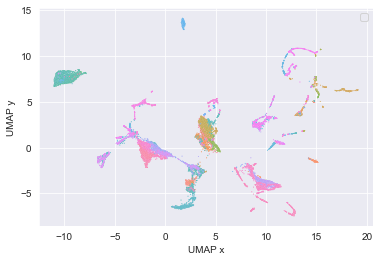

In [59]:
# Plot the distribution depending on the deployment id to make sure not all the clusters are one individual cluster
sns.scatterplot(x=x_umap[:, 0], y=x_umap[:, 1], hue=df_clean['etn_id'].astype(str), s=1)
plt.xlabel('UMAP x')
plt.ylabel('UMAP y')
plt.legend('')
plt.show()

We can see that some clusters are unique deployments, but not all of them. It makes sense that one deployment of 1 h in a single location has similar sounds, so the fact that the samples of each deployment are close by is a good sign. However, if we would not have mixing clusters, the clustering method would not make a lot of sense.

### Let's make some spatial plots to see how our clusters are distributed!

In [69]:
geo_folder = pathlib.Path('./geo')

# Load the background geographical information
bathymetry_path = geo_folder.joinpath('bathymetry_bmz_emodnet_2020.tif')
bathymetry_xr = rioxarray.open_rasterio(bathymetry_path)

borders_EEZ = geo_folder.joinpath('boundaries/eez_boundaries_v10_BE_epsg4326.shp')
borders_df = geopandas.read_file(borders_EEZ)

benthic_habitat_path = geo_folder.joinpath('benthic_habitat/Habitat Suitability2.shp')
benthic_map = geopandas.read_file(benthic_habitat_path)

seabed_habitat_path = geo_folder.joinpath('seabed_habitat/seabedhabitat_BE.shp')
seabed_map = geopandas.read_file(seabed_habitat_path)
seabed_map.loc[~seabed_map.Allcomb.isin(df.seabed_habitat.unique())] = np.nan  # Ignore the classes that were not sampled


# Get the metadata
metadata = pd.read_csv(raw_data_folder.joinpath('data_summary_mda.csv'))

In [70]:
# Get the shipwrecks
url = 'https://wrakkendatabank.api.afdelingkust.be/v1/wrecks'
response = requests.get(url)
if response.status_code == 200:
    wrecks_json = response.json()['wrecks']
    wrakken_df = pd.DataFrame(wrecks_json)
    wrakken_df['x'] = None
    wrakken_df['y'] = None
    for i, row in wrakken_df.iterrows():
        wrakken_df.loc[i, ['x', 'y']] = row['pseudoMercatorCoordinate']

wrakken = geopandas.GeoDataFrame(wrakken_df,
                                 geometry=geopandas.points_from_xy(x=wrakken_df['x'],
                                                                   y=wrakken_df['y']),
                                 crs='EPSG:3857')

First, we will start plotting all our samples in the Belgian Part of the North Sea

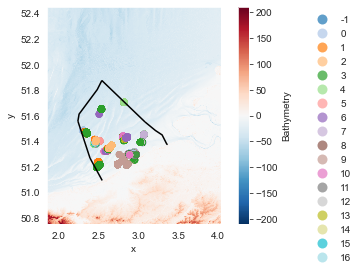

In [71]:
# Some geo plots
fig, ax = plt.subplots()
bathymetry_xr.plot(ax=ax, cbar_kwargs={'label': 'Bathymetry'})
borders_df.to_crs('epsg:4326').plot(ax=ax, color='k')
df_clean.to_crs('epsg:4326').plot('clusters', legend=True, alpha=0.7,
                                                   categorical=True, cmap=cmap, ax=ax,
                                                   legend_kwds={'framealpha': 0, 'bbox_to_anchor': (1.8, 1)}
                                                   )
plt.title(None)
plt.savefig(output_folder.joinpath('img/clusters_distribution.png'))

But we already see that this a bit messy to understand, because most of our samples overlap. Let's check them deployment by deployment.

In [75]:
# Define a plotting function to plot the deployment temporally
def plot_temporal_evolution(deployment_path, etn_id, df_complete, secondary_axis, secondary_axis_label):
    # Get the original 1-sec resolution
    deployment = xarray.open_dataset(raw_data_folder.joinpath('deployments', deployment_path))
    deployment = deployment.sortby('datetime')
    deployment_mask = df_complete.loc[df_complete.etn_id == etn_id].index

    df_deployment = df_complete.loc[deployment_mask][['clusters', 'datetime', 'rf_prediction', secondary_axis]]
    df_deployment = df_deployment.set_index('datetime')
    ds_deployment = df_deployment.to_xarray()

    ds_deployment = ds_deployment.sortby('datetime')
    ds_deployment.reindex({'datetime': deployment.datetime.values},
                          tolerance=datetime.timedelta(seconds=1), method='nearest')
    ds_deployment['clusters'] = ds_deployment['clusters'].expand_dims({'id': [0, 1]})
    ds_deployment['rf_prediction'] = ds_deployment['rf_prediction'].expand_dims({'id': [0, 1]})
    ds_deployment = ds_deployment.fillna(-1)
    ds_deployment['rf_prediction'] = ds_deployment['rf_prediction'].astype(int)

    # plots with spectra
    # Get the clusters present for the legend
    clusters_present_real = np.array(df_deployment['clusters'].unique()) + 1
    clusters_present_predicted = np.array(df_deployment['rf_prediction'].unique()) + 1
    clusters_present = np.unique(np.concatenate([clusters_present_real, clusters_present_predicted]))
    clusters_present.sort()

    fig, [ax, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 4), sharex=True,
                                       gridspec_kw={'height_ratios': [1, 1, 2.5]})
    ds_deployment['clusters'].plot.pcolormesh(cmap=cmap, vmin=unique_clusters.min(), vmax=unique_clusters.max(),
                                              add_colorbar=False, ax=ax)
    ax.yaxis.set_visible(False)
    ax.set_xlabel('')
    ax.set_title('Acoustic categories')
    ds_deployment['rf_prediction'].plot.pcolormesh(cmap=cmap, vmin=unique_clusters.min(),
                                                   vmax=unique_clusters.max(),
                                                   add_colorbar=False, ax=ax2)
    ax2.yaxis.set_visible(False)
    ax2.set_xlabel('')
    ax2.set_title('Predicted categories RF')

    ax_1 = ax.twinx()
    ds_deployment['current'].plot(ax=ax_1, color='k')
    ax_1.set_ylabel('Current [m/s]')

    deployment['oct3'].T.plot.pcolormesh(add_colorbar=False, ax=ax3, yscale='symlog',
                                         x='datetime', y='frequency', cmap='Greys')
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax3.set_xlabel('Time of the day (%s)' % deployment.datetime.dt.date.isel(id=0).values)
    ax3.set_ylabel('Frequency [Hz]')

    handles = []
    for cluster_number in clusters_present:
        cl_patch = mpatches.Patch(color=cmap.colors[cluster_number], label=str(cluster_number-1))
        handles.append(cl_patch)
    fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.05, 0.75), title='Categories')
    fig.tight_layout()
    plt.savefig(deployments_folder.joinpath('deployment_%s_spectra_current.png' % etn_id), transparent=True, dpi=350,
                bbox_inches="tight")
    plt.show()

    fig, [ax, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 4), sharex=True,
                                       gridspec_kw={'height_ratios': [1, 1, 2.5]})
    ds_deployment['clusters'].plot.pcolormesh(cmap=cmap, vmin=unique_clusters.min(), vmax=unique_clusters.max(),
                                              add_colorbar=False, ax=ax)
    ax.yaxis.set_visible(False)
    ax.set_xlabel('')
    ax.set_title('Acoustic categories')
    ds_deployment['rf_prediction'].plot.pcolormesh(cmap=cmap, vmin=unique_clusters.min(),
                                                   vmax=unique_clusters.max(),
                                                   add_colorbar=False, ax=ax2)
    ax2.yaxis.set_visible(False)
    ax2.set_xlabel('')
    ax2.set_title('Predicted categories RF')

    ax_1 = ax.twinx()
    ds_deployment[secondary_axis].plot(ax=ax_1, color='k')
    ax_1.set_ylabel(secondary_axis_label)

    deployment['oct3'].T.plot.pcolormesh(add_colorbar=False, ax=ax3, yscale='symlog',
                                         x='datetime', y='frequency', cmap='Greys')
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax3.set_xlabel('Time of the day (%s)' % deployment.datetime.dt.date.isel(id=0).values)
    ax3.set_ylabel('Frequency [Hz]')

    handles = []
    for cl in clusters_present:
        cl_patch = mpatches.Patch(color=cmap.colors[cl], label=str(cl-1))
        handles.append(cl_patch)
    fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.05, 0.75), title='Categories')
    fig.tight_layout()
    plt.savefig(deployments_folder.joinpath('deployment_%s_spectra_salinity.png' % etn_id),
                transparent=True, dpi=350, bbox_inches="tight")
    plt.show()

In [76]:
selected_deployments = [12650, 9810, 12681, 13246]

for i, row in metadata.iterrows():
    if row.etn_id in selected_deployments:
        plot_temporal_evolution(row.deployment_path, row.etn_id, df, secondary_axis='salinity', secondary_axis_label='Salinity [PSU]')

    #
    # # plots with background
    # mask_id = str(etn_id)
    # plot_mask_with_all_backgrounds(df=df_complete, mask=deployment_mask, bathymetry_xr=bathymetry_xr,
    #                                wrakken=wrakken, benthic_map=benthic_map, seabed_map=seabed_map,
    #                                clusters_cmap=cmap, mask_id=mask_id, save_folder=deployments_folder)

KeyError: "['clusters', 'rf_prediction'] not in index"

This is already better looking. Let's look now at a single deployment. We will not show all of them here to not collapse the notebook, but we selected a few interesting ones.

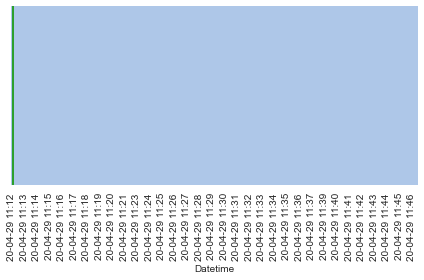

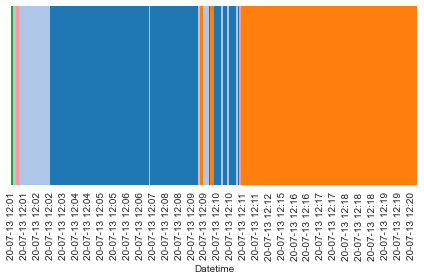

In [45]:
for etn_id in [9807, 9825]:
    deployment_mask = df_clean.loc[df_clean.etn_id == etn_id]
    df_clusters = pd.DataFrame(df_clean.loc[deployment_mask.index][['clusters']].transpose().values.astype(int),
                               columns=df_clean.loc[deployment_mask.index].datetime.round('min').dt.strftime(
                                   '%y-%m-%d %H:%M'))
    fig, ax = plt.subplots()
    sns.heatmap(data=df_clusters, cmap=cmap, cbar=False, ax=ax, vmin=unique_clusters.min(),
                vmax=unique_clusters.max())
    ax.yaxis.set_visible(False)
    plt.tight_layout()
    plt.xlabel('Datetime')
    plt.savefig(output_folder.joinpath('deployments/deployment_%s_temporal.png' % etn_id), transparent=True)
    plt.show()

In [ ]:
df_clean['rf_prediction'] = -1
df_clean.loc[df.index, ['clusters', 'rf_prediction']] = df[['clusters', 'rf_prediction']].values
df_clean['clusters'] = df_clean['clusters'].astype('category')
df_clean['rf_prediction'] = df_clean['rf_prediction'].astype('category')
df_clean.to_pickle(output_folder.joinpath('df_complete_with_clusters.pkl'))